In [148]:
# init imports
import pandas as pd
import sqlalchemy as sa
import psycopg2
import matplotlib.pyplot as plt
import datetime

In [76]:
# create postgresql database with docker and init params for connection
# docker run  --name io-postgres -e POSTGRES_USER=master -e POSTGRES_PASSWORD=master-postgres-token -e POSTGRES_DB=io_db  -d  -p 5050:5432 postgres
host = 'localhost'
database = 'io_db'
port = 5050
user = 'master'
password = 'master-postgres-token'

In [77]:
# prepare url and engine
url = 'postgresql://{0}:{1}@{2}:{3}/{4}'.format(user, password, host, port, database)
engine = sa.create_engine(url)

In [78]:
def create_table(q, engine):
    """Create table with query and engine"""
    with engine.connect() as con:
        con.execute(q)

In [79]:
def insert_values(v, engine):
    """Insert values into database"""
    with engine.connect() as con:
        for value in v:
            con.execute(value)

In [80]:
# create a table
prices_table_q = (
    """        
        CREATE TABLE Prices (
            date_start DATE NOT NULL,
            product VARCHAR(8) NOT NULL,
            price INT NOT NULL
        )
    """
)
create_table(prices_table_q, engine)

In [81]:
# insert values
prices_table_v = (
    """INSERT INTO Prices VALUES ('1970-01-01', 'A', 20) """,
    """INSERT INTO Prices VALUES ('2019-02-04', 'B', 45) """,
    """INSERT INTO Prices VALUES ('2018-05-11', 'A', 27) """,
)
insert_values(prices_table_v, engine)

In [82]:
# check a table and values
df = pd.read_sql_query('select * from Prices',con=engine)
df

,date_start,product,price
0,1970-01-01,A,20
1,2019-02-04,B,45
2,2018-05-11,A,27


In [83]:
# return actual prices
q = (
    """
        SELECT date_start as date, product, price as actual_price
        FROM Prices
        WHERE date_start = (select MAX(date_start) FROM Prices as temp WHERE temp.product  = Prices.product)
    """       
)

df = pd.read_sql_query(q,con=engine)
df

,date,product,actual_price
0,2019-02-04,B,45
1,2018-05-11,A,27


In [84]:
# return tuple of dates and prices
q = (
    """
        SELECT date_start, price
        FROM Prices
        WHERE product = %(product_name)s
        ORDER BY date_start ASC
        
    """
)

def get_data_by_product_name(product_name, q, engine):
    """Get prices and start dates by product name"""
    df = pd.read_sql_query(q,con=engine,
                      params={'product_name':product_name})
    return tuple(zip(df.values[0],df.values[1]))

values = get_data_by_product_name('A', q, engine)

values


((datetime.date(1970, 1, 1), datetime.date(2018, 5, 11)), (20, 27))

In [85]:
# create a sales table
sales_table_q = (
    """
        CREATE TABLE Sales (
            product VARCHAR(8) NOT NULL,
            date DATE NOT NULL,
            amount INT NOT NULL,
            country VARCHAR(8) NOT NULL
        )
    
    """
)
create_table(sales_table_q, engine)

In [86]:
# insert values
sales_table_v = (
    """INSERT INTO Sales VALUES ('A','2019-02-15', 92, 'RU') """,
    """INSERT INTO Sales VALUES ('B','2019-05-06', 113, 'GB') """,
    """INSERT INTO Sales VALUES ('B','2019-06-20', 12, 'NA') """,
)
insert_values(sales_table_v, engine)

In [87]:
# check a sales table and values
df = pd.read_sql_query('select * from Sales',con=engine)
df

,product,date,amount,country
0,A,2019-02-15,92,RU
1,B,2019-05-06,113,GB
2,B,2019-06-20,12,NA


In [126]:
def compute_revenue(engine):
    """Return a table with computing revenue"""
    q = (
    """
        SELECT Sales.product, Sales.date, Sales.amount, Sales.country, (prices_and_dates.price * Sales.amount) AS revenue 
        FROM Sales 
        INNER JOIN
            (
                SELECT Prices.price, nearest_dates.date
                FROM Prices
                INNER JOIN
                    (
                        SELECT Sales.date, MAX( Prices.date_start ) AS nearest_date
                        FROM Sales
                        INNER JOIN Prices ON Sales.date > Prices.date_start AND Sales.product  = Prices.product
                        GROUP BY Sales.date
                    ) AS nearest_dates 
                ON nearest_dates.nearest_date = Prices.date_start
            ) AS prices_and_dates
        ON prices_and_dates.date = Sales.date
    """
    )
    return pd.read_sql_query(q,con=engine)


In [128]:
df = compute_revenue(engine)
df

,product,date,amount,country,revenue
0,B,2019-06-20,12,NA,540
1,B,2019-05-06,113,GB,5085
2,A,2019-02-15,92,RU,2484


In [150]:
def pie_revenue(dataframe):
    """Plot proportional representation of revenue by country"""
    new_df = pd.DataFrame({'revenue': dataframe['revenue'].values},index=dataframe['country'][:])
    new_df.plot.pie(y='revenue', figsize=(10, 10))

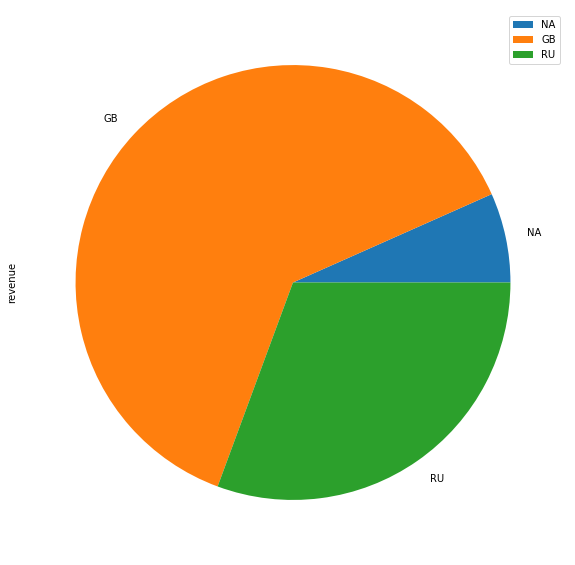

In [153]:
df = pd.read_sql_query(q,con=engine)
pie_revenue(df)

In [159]:
def pie_revenue_with_periods(df, first, last):
    """Plot proportional representation of revenue by country over a period of time"""
    first = datetime.datetime.strptime(first, '%Y-%m-%d').date()
    last = datetime.datetime.strptime(last, '%Y-%m-%d').date()
    df = df[(df['date'] > first) & (df['date'] < last)]
    new_df = pd.DataFrame({'revenue': df['revenue'].values},index=df['country'])
    new_df.plot.pie(y='revenue', figsize=(10, 10))

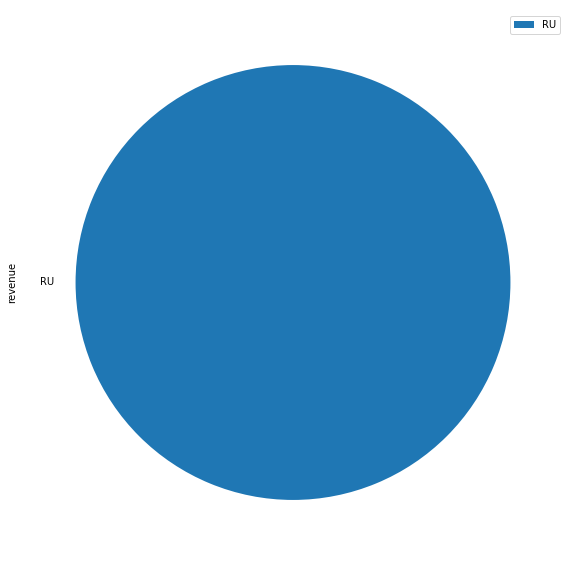

In [160]:
df = pd.read_sql_query(q,con=engine)
pie_revenue_with_periods(df,'2019-02-01', '2019-05-01')